In [1]:
from collections import OrderedDict

import torch
from torch import nn

import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torcheval import metrics


In [2]:
BATCH_SIZE = 16
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# A:

In [3]:
def get_data_sets_and_loaders(resize=224):
    # dataset contains PIL images. with RGB values of 0-255
    # transforms.ToTensor transforms them from uint8 to be between [0-1] floats
    transform = transforms.Compose([
        transforms.Resize(resize),  # Match freaking cifer 32x32 input to resnet18 trained weights over 224x224 images.
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    cifar10_train_ds = datasets.CIFAR10("../data/", train=True, download=True, transform=transform)
    cifar10_test_ds = datasets.CIFAR10("../data/", train=False, download=True, transform=transform)

    cf10_train_dl = DataLoader(cifar10_train_ds, batch_size=BATCH_SIZE, shuffle=True)
    cf10_test_dl = DataLoader(cifar10_test_ds, batch_size=BATCH_SIZE, shuffle=False)
    return cifar10_train_ds, cifar10_test_ds, cf10_train_dl, cf10_test_dl

In [4]:
# D, E:

In [5]:
def get_modified_resnet18(n_classes=10, pretrained=True) -> nn.Module:
    """ Returns modified resnet18 model """
    weights = None
    if pretrained:
        weights = models.ResNet18_Weights.IMAGENET1K_V1
    resnet18 = models.resnet18(weights=weights)
    # Overwriting resnet18 output layer
    resnet18.fc = nn.Linear(in_features=resnet18.fc.in_features, out_features=n_classes, bias=True, device=DEVICE)

    # Freezing all grads beside last layer ('fc')
    for name, param in resnet18.named_parameters():
        if name.startswith('fc'):
            param.requires_grad = True
        else:
            param.requires_grad = False
    return resnet18

In [6]:
# We will use previous work to write train and evaluation loops

In [7]:


def validation_loop(model, val_loader, loss_fn) -> (float, float):
    """ validation loop """
    val_loss = 0.
    metric = metrics.MulticlassAccuracy(device=DEVICE)
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            loss = loss_fn(preds, y)
            metric.update(preds, y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss, metric.compute()


def train_model(
        model: nn.Module,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        loss_fn: nn.Module,
        epochs: int = 10,
        verbose: int = 1,
        verbose_batch: int = 1,
        lr: float = 1e-4,
        wd: float = 0.05) -> nn.Module:
    """
    Given train/validation set, train the model `epochs` epochs, and validates at each epoch over
    the validation set.
    Required metric is Accuracy.

    :param model:
    :param train_loader:
    :param valid_loader:
    :param task: Task (currently 'classification' or 'regression')
    :param epochs:
    :param verbose: [0, 1, 2] Level of printing information (0 None, 2 Max)
    :param verbose_batch: if verbose is 2, how many batches before printing metrices and loss.
    :param lr: learning rate
    :param wd: weight decay
    :return: a model
    """
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    metric = metrics.MulticlassAccuracy(device=DEVICE)
    for epoch in range(epochs):
        running_loss = 0.
        model.train()
        metric.reset()
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            preds = model(x)
            loss = loss_fn(preds, y)
            metric.update(preds, y)
            loss.backward()
            opt.step()
            running_loss += loss.item()

            # Print every `verbose_batch` batches
            if verbose >= 2 and i % verbose_batch == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], "
                      f"Step [{i}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f}", sep=',')

        # End of epoch. Run validation and print outcomes
        avg_val_loss, metric_val = validation_loop(model, valid_loader, loss_fn)
        if verbose >= 1:
            print(f"Epoch [{epoch + 1:4}/{epochs}]", end=f", ")
            print(f"trn los: {running_loss / len(train_loader):8.4f},", f"trn acc: {metric.compute():6.4f}",
                  end=', ')
            print(f"val loss: {avg_val_loss:8.4f}, val acc: {metric_val:6.4f}")

    return model

In [8]:
def train_resnet18_toplayer():
    n_classes = 10

    _, _, cf10_train_dl, cf10_test_dl = get_data_sets_and_loaders()

    resnet18 = get_modified_resnet18(n_classes=n_classes, pretrained=True)
    resnet18.to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    model = train_model(resnet18, cf10_train_dl, cf10_test_dl, loss_fn,
                        epochs=3, verbose=2, verbose_batch=100, lr=1e-4, wd=0.)
    # torch.save(model.state_dict(), '../assets/weights_1.pt')
    return model

resnet18_cifar10 = train_resnet18_toplayer()

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/3], Step [0/3125], Loss: 2.3102
Epoch [1/3], Step [100/3125], Loss: 2.3007
Epoch [1/3], Step [200/3125], Loss: 1.9957
Epoch [1/3], Step [300/3125], Loss: 1.8944
Epoch [1/3], Step [400/3125], Loss: 1.7939
Epoch [1/3], Step [500/3125], Loss: 1.6115
Epoch [1/3], Step [600/3125], Loss: 1.5614
Epoch [1/3], Step [700/3125], Loss: 1.3409
Epoch [1/3], Step [800/3125], Loss: 1.4368
Epoch [1/3], Step [900/3125], Loss: 1.3725
Epoch [1/3], Step [1000/3125], Loss: 1.3183
Epoch [1/3], Step [1100/3125], Loss: 1.3420
Epoch [1/3], Step [1200/3125], Loss: 1.3094
Epoch [1/3], Step [1300/3125], Loss: 1.2006
Epoch [1/3], Step [1400/3125], Loss: 1.4517
Epoch [1/3], Step [1500/3125], Loss: 1.2113
Epoch [1/3], Step [1600/3125], Loss: 1.2597
Epoch [1/3], Step [1700/3125], Loss: 1.1644
Epoch [1/3], Step [1800/3125], Loss: 1.2363
Epoch [1/3], Step [1900/3125], Loss: 1.0352
Epoch [1/3], Step [2000/3125], Loss: 1.1469
Epoch [1/3],

In [9]:
# het, tet: 
# Now we need to analyze the results. 
# We will build a few helper functions
# We need to find mistakes and show them.
# In order to show them we need to `reverse` our transformation
# Plotting function used heavily with GPT and is not original as the rest of the work.

def reverse_transform(img_tensor):
    """reverse original transformation"""
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return img_tensor * std + mean

def load_model_from_disk(path, *args, **kwargs):
    model = get_modified_resnet18(*args, **kwargs)
    model.load_state_dict(torch.load(path, weights_only=True))
    model.to(DEVICE)
    return model


def get_mistakes(model, data_loader):
    mistakes = []
    model.eval()
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            # getting the fully connected 10 dim output from model
            logits = model(x)
            # softmax over the feature dim (not batch) giving us
            # len(row) = 10, sum(row) = 1
            probs = F.softmax(logits, dim=1)
            # torch max returns (max prob, indices)
            # indices can be converted to original class and be compared to gt_label (gt = ground truth)
            pred_confidence, preds = torch.max(probs, dim=1)

            # Building the mistakes array. inserting only pred != gt ..
            for i in range(len(y)):
                gt = y[i].item()
                pred = preds[i].item()
                confidence = pred_confidence[i].item()
                if pred != gt:
                    mistakes.append({
                        'image': x[i].cpu(),
                        'true_label': gt,
                        'pred_label': pred,
                        'confidence': confidence
                    })
    mistakes = sorted(mistakes, key=lambda m: m['confidence'], reverse=True)
    return mistakes


def show_mistakes(mistakes, class_names):
    # If plotting looks generic, it was very much relied on GPT.
    n = len(mistakes)
    fig, axs = plt.subplots(n, 2, figsize=(10, 4 * n))

    for i, mistake in enumerate(mistakes):
        img = reverse_transform(mistake['image'])
        # premute: convert CHW → HWC,
        # clamp. cuts negatives to 0 and x > 1 to 1.
        # no need to go back to 0-255 since matplotlib imshow can handle it
        img = img.permute(1, 2, 0).clamp(0, 1).numpy()

        axs[i][0].imshow(img)
        axs[i][0].axis('off')
        # Show text on right
        text = (
            f"True Label: {class_names[mistake['true_label']]}\n"
            f"Predicted: {class_names[mistake['pred_label']]}\n"
            f"Confidence: {mistake['confidence']:.2f}"
        )
        axs[i][1].text(0.0, 0.5, text, fontsize=26, va='center', fontfamily='monospace')
        axs[i][1].axis('off')

    plt.tight_layout()
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


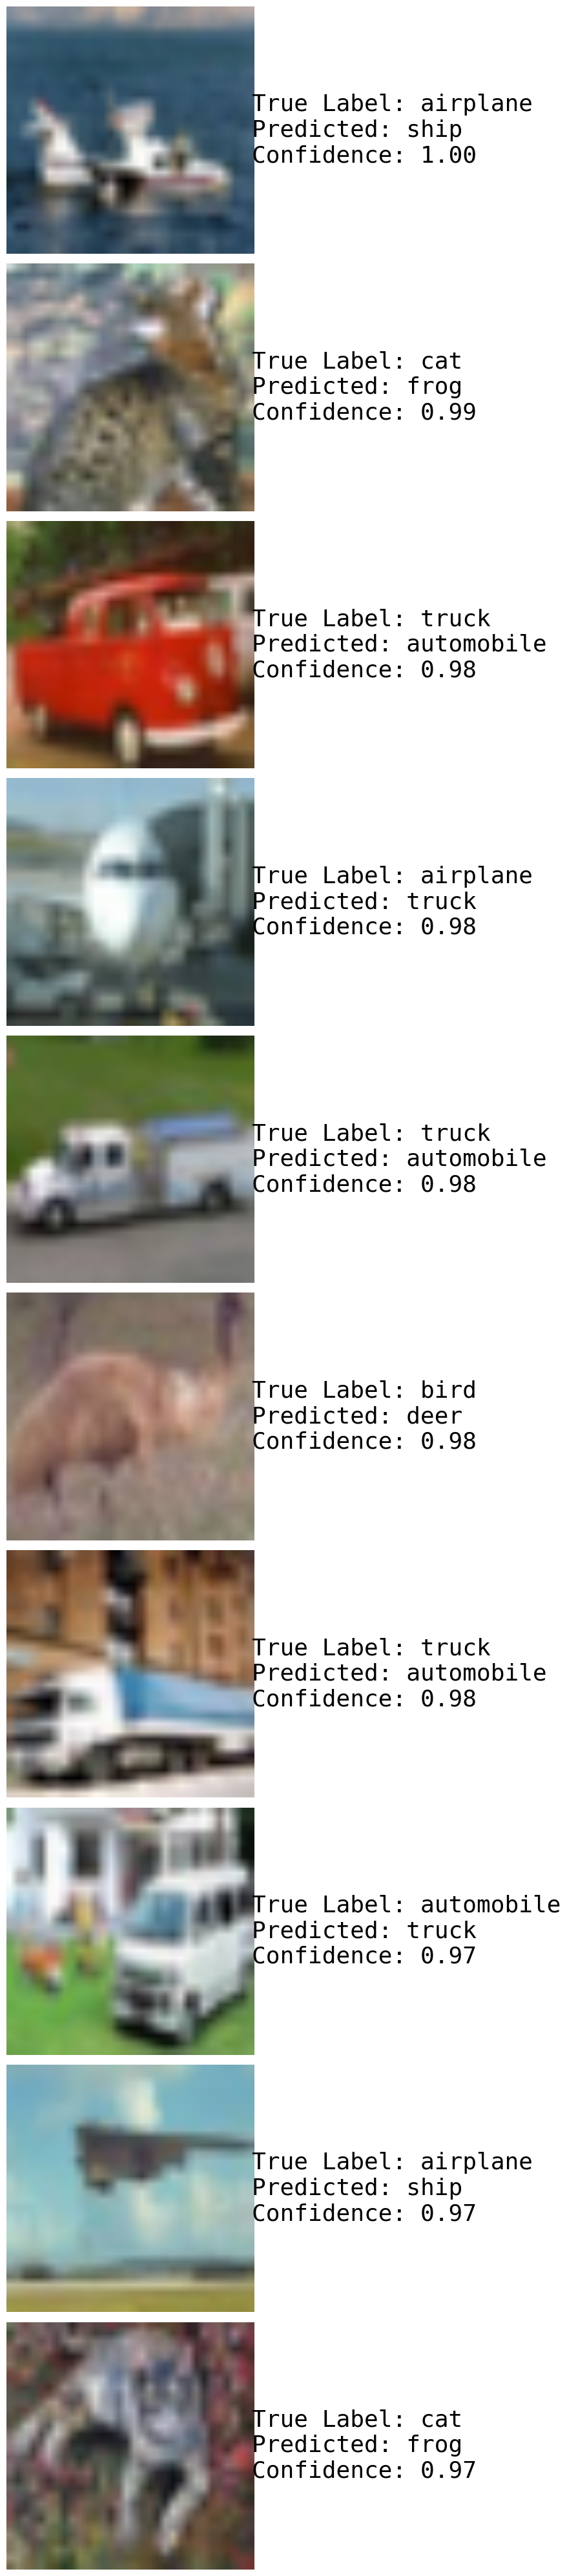

In [11]:
def analyze_mistakes(top_k=10, model=None):
    _, cf10_test_ds, _, cf10_test_dl = get_data_sets_and_loaders()
    n_classes = len(cf10_test_ds.classes)

    if not model:
        model = load_model_from_disk('../assets/weights_1.pt', n_classes=n_classes, pretrained=True)

    mistakes = get_mistakes(model, cf10_test_dl)
    show_mistakes(mistakes[:top_k], cf10_test_ds.classes)

analyze_mistakes(10, model=resnet18_cifar10)

In [12]:
# yud
class MyResidualBlock(nn.Module):
    """ Designing the residual block with additional parameter, down_sample.
    Which decides if our residual block will stride 2 steps instead of 1
    Which in terms shrink H and W. by factor of 2. """

    def __init__(self, in_channels, out_channels, down_sample=False):
        super().__init__()
        _stride = 2 if down_sample else 1

        # the conv path constructed from 2 conv with batch_norm, and relu in the first pass
        self.conv_layer = nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=_stride, padding=1, bias=False)),
            ("bn1", nn.BatchNorm2d(out_channels, affine=True)),
            ("relu1", nn.ReLU(inplace=True)),
            ("conv2", nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)),
            ("bn2", nn.BatchNorm2d(out_channels, affine=True))
        ]))

        # skip path, in case we down sample or channels do not align, we align them.
        # otherwise we simply use identity.
        if down_sample or in_channels != out_channels:
            self.skip_layer = nn.Sequential(OrderedDict([
                ("conv_skip",
                 nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=_stride, padding=1, bias=False)),
                ("bn_skip", nn.BatchNorm2d(out_channels, affine=True)),
            ]))
        else:
            self.skip_layer = nn.Identity()

    def forward(self, x: torch.Tensor):
        conv = self.conv_layer(x)
        skip = self.skip_layer(x)
        return F.relu(conv + skip)


class MyMiniResNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()

        # this mini resnet attacks the cifar10 dataset, so no max pool. use small kernel size.
        self.stem = nn.Sequential(OrderedDict([
            ("conv_stem", nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)),
            ("bn_stem", nn.BatchNorm2d(64)),
            ('relu_stem', nn.ReLU(inplace=True))
        ]))

        # for cifar10
        # 32x32 -> 32x32 -> 16x16 -> 8x8 (x256)
        self.block1 = MyResidualBlock(64, 64, down_sample=False)
        self.block2 = MyResidualBlock(64, 128, down_sample=True)
        self.block3 = MyResidualBlock(128, 256, down_sample=True)

        # 8x8x256 avg pool -> 256x1x1, flatten -> 256 -> 10
        self.head = nn.Sequential(OrderedDict([
            ("ada_avg_pool", nn.AdaptiveAvgPool2d((1, 1))),
            ("flatten", nn.Flatten()),
            ('fc', nn.Linear(256, num_classes))
        ]))

    def forward(self, x: torch.Tensor):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.head(x)
        return x

In [13]:
def train_custom_resnet():
    n_classes = 10
    _, _, cf10_train_dl, cf10_test_dl = get_data_sets_and_loaders(resize=32)
    my_resnet = MyMiniResNet(3, n_classes)
    my_resnet.to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    model = train_model(my_resnet, cf10_train_dl, cf10_test_dl, loss_fn,
                        epochs=3, verbose=2, verbose_batch=100, lr=1e-4, wd=0.)
    # torch.save(model.state_dict(), '../assets/weights_2.pt')
    return model

custom_resnet_cifar10 = train_custom_resnet()

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/3], Step [0/3125], Loss: 2.3227
Epoch [1/3], Step [100/3125], Loss: 1.9334
Epoch [1/3], Step [200/3125], Loss: 1.5096
Epoch [1/3], Step [300/3125], Loss: 1.9416
Epoch [1/3], Step [400/3125], Loss: 1.3970
Epoch [1/3], Step [500/3125], Loss: 1.6197
Epoch [1/3], Step [600/3125], Loss: 1.7431
Epoch [1/3], Step [700/3125], Loss: 1.0688
Epoch [1/3], Step [800/3125], Loss: 1.5463
Epoch [1/3], Step [900/3125], Loss: 1.2303
Epoch [1/3], Step [1000/3125], Loss: 1.2199
Epoch [1/3], Step [1100/3125], Loss: 1.3459
Epoch [1/3], Step [1200/3125], Loss: 1.5957
Epoch [1/3], Step [1300/3125], Loss: 1.0895
Epoch [1/3], Step [1400/3125], Loss: 1.2242
Epoch [1/3], Step [1500/3125], Loss: 1.0919
Epoch [1/3], Step [1600/3125], Loss: 1.4378
Epoch [1/3], Step [1700/3125], Loss: 1.3098
Epoch [1/3], Step [1800/3125], Loss: 1.2306
Epoch [1/3], Step [1900/3125], Loss: 1.1820
Epoch [1/3], Step [2000/3125], Loss: 1.5072
Epoch [1/3],

In [ ]:
# Comparison between the results in doc file.